In [2]:
from ecc import *
from random import randint, sample

# Polynomials over reals

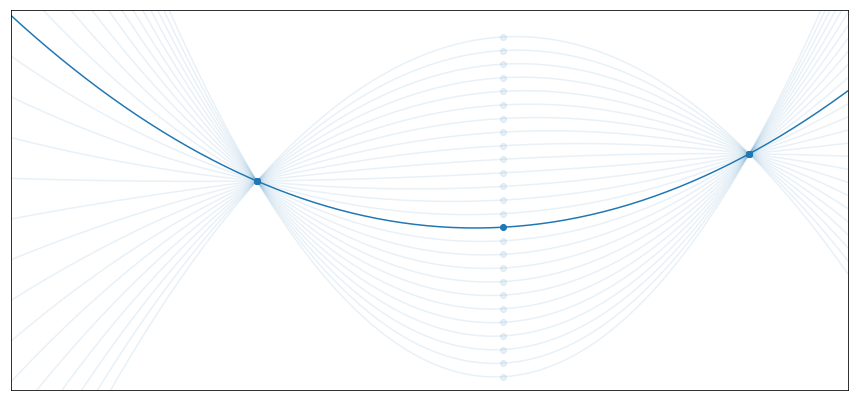

In [5]:
from matplotlib import pyplot as plt
import numpy as np

def poly(x, points):
    s = 0
    for j, (xj, fj) in enumerate(points):
        sj = fj
        for i, (xi, fi) in enumerate(points):
            if xi != xj:
                sj *= (x - xi) / (xj - xi)
        s += sj
    return s

plt.figure(figsize=[15,7])
points_arr = [[(5,7), (10, i), (15,17)] for i in range(-65,65,5)]
for i, points in enumerate(points_arr):
    if i == 11:
        alpha = 1
    else:
        alpha = 0.1
    xs = np.linspace(0, 17, 200)
    ys = poly(xs, points)
    plt.plot([p[0] for p in points], [p[1] for p in points], "o", color="C0", alpha=alpha)
    plt.plot(xs, ys, color="C0", alpha=alpha)
plt.xlim(0,17)
plt.ylim(-70,70)
plt.xticks([])
plt.yticks([])
# plt.savefig("poly.svg")
plt.show()

# Moving to Finite field

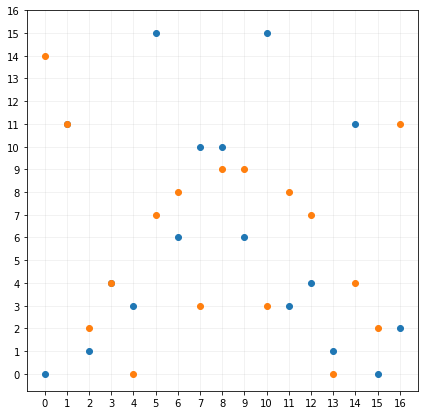

In [38]:
prime = 17
xs = np.arange(prime)
ys = poly(xs, [(1,11), (2,1), (3, 4)]) % prime
ys2 = poly(xs, [(1,11), (2,2), (3, 4)]) % prime

plt.figure(figsize=[7,7])
plt.plot(xs, ys, "o")
plt.plot(xs, ys2, "o")
plt.xticks(range(17))
plt.yticks(range(17))
plt.grid(alpha=0.2)
# plt.savefig("poly17.svg")
plt.show()

# Bitcoin curve

In [71]:
# N is a group order of the bitcoin curve
class N256Field(FieldElement):

    def __init__(self, num, prime=None):
        super().__init__(num=num, prime=N)

    def hex(self):
        return '{:x}'.format(self.num).zfill(64)

    def __repr__(self):
        return self.hex()

# N256Field is an integer defined over finite field modulo N
def get_random_secret():
    return N256Field(randint(0, N-1))

# random secret we want to split:
secret = get_random_secret()
secret

7f259711c4ed3a99d4d7f2ad18d8e7611eb1e92ee84e8e11f38b614fabc9454d

# Classic Shamir Secret Sharing Scheme

## Splitting the secret

To split a secret we need to define a random polynomial of order m-1. It has a form:

$f(x) = s + r_1 \cdot x + r_2 \cdot x^2 + ... + r_{m-1} \cdot x^{m-1}$

Here $r_1, r_2, ..., r_{m-1}$ are random numbers and polynomial gives us our secret at $x=0$: 

$f(0) = s$

Share `i` is calculated as values of this polynomial at $x = i$:

$s_i = f(i)$

We need to store pairs $(x_i, f_i)$ to reconstruct the secret.

In [72]:
def get_shares(secret, m, n):
    """
    Returns n tuples (i, share_i).
    m of n tupes can reconstruct the secret.
    """
    # choose random polynomial coefficients of degree m-1
    coefficients = [randint(0, N-1) for i in range(m-1)]
    # calculate secret shares
    shares = []
    for i in range(1, n+1):
        share = secret + N256Field(sum([c*i**(k+1) for k, c in enumerate(coefficients)]) % N)
        shares.append((i, share))
    return shares

In [73]:
# using 3 of 5 scheme
m = 3
n = 5
shares = get_shares(secret, m, n)
shares

[(1, c8da7f0f434207f4c9077ea19120d1902951affc554e94038f2003a87ae56ee5),
 (2, 9230fa859e842ed0a1f50d7da9ea76f7d4fd76a8c5aa87d8ec9c93e25c5244a6),
 (3, db290974d6b3af2d5fa09f416335d796dc641a1ae8ab09cdcbd3708a204607d1),
 (4, a3c2abdcebd0890b020a33ecbd02f36e84d6bd6c0f0779a66cf23b12f68a7725),
 (5, ebfde1bddddabc698931cb7fb751ca7d89043d82e808779e8fcb5209af55d3e3)]

## Recovering the secret from shares

To recover the secret we need `m` shares: pairs of values $(x_i, f_i)$.

It is enough to reconstruct full polynomial and calculate the secret:

$s = \sum_{j=1}^{m} \prod_{i \neq j} \frac{x_i}{x_j - x_i} \cdot f_j$

In [74]:
def recover_secret(shares):
    """
    Calculates the secret from m shares
    """
    s = N256Field(0)
    for j, (xj, fj) in enumerate(shares):
        sj = fj
        for i, (xi, fi) in enumerate(shares):
            if xi != xj:
                sj *= N256Field(xi) / (N256Field(xj) - N256Field(xi))
        s += sj
    return s

In [75]:
# m of n shares
shares_part = sample(shares, m)

recovered_secret = recover_secret(shares_part)
print(recovered_secret)
if recovered_secret == secret:
    print("Ok, secret is recovered")
else:
    print("Failed to recover secret")

7f259711c4ed3a99d4d7f2ad18d8e7611eb1e92ee84e8e11f38b614fabc9454d
Ok, secret is recovered


# Verifiable Secret Sharing

The scheme above is fine, but if you receive your secret share you can't make sure it is valid. The easiest way to make sure all shares are valid is to try to reconstruct the secrets, but this requires collaboration from all m parties. 

There is another way.

In [76]:
import hashlib, hmac

def generate_point(m=b'random point'):
    """
    Generates random point H on the curve such that no one knows k such that k*G = H
    To do this we hash some data and treat at as x-coordinate of a point
    If we fail to find a point at this x -> change the hash by incrementing salt
    """
    salt = 0
    point = None
    while point is None:
        h = hashlib.sha256(m + salt.to_bytes(1, 'little')).digest()
        sec = b'\x02'+h
        try:
            point = S256Point.parse(sec)
        except:
            salt += 1
    return point

H = generate_point()
H

Point(5b86a9222256443b6cf7e2100ea610b9dab5a88e9f94cb4591a21ddf38b2215f,e985fa3591ecd2d0d073269cc57fe9aca57faeffbfaf6998ca7e11626ada6ed6)

In [77]:
def E(s, t):
    return s * G + t * H

In [78]:
def get_verifiable_shares(secret, m, n):
    """
    Returns n tuples (i, share_i), coefficient shares E(Fi, Gi) and commitment E(s,t).
    m of n tupes can reconstruct the secret.
    """
    # choose random polynomial coefficients of degree m-1
    F_coefficients = [randint(0, N-1) for i in range(m-1)]
    # the same for verification polynom
    G_coefficients = [randint(0, N-1) for i in range(m-1)]

    # commitment to the coefficients
    e_arr = [E(f, g) for f, g in zip(F_coefficients, G_coefficients)]
    
    t = get_random_secret()

    # calculate secret shares
    shares = []
    for i in range(1, n+1):
        share = (secret + N256Field(sum([c*i**(k+1) for k, c in enumerate(F_coefficients)]) % N))
        t_share = (t + N256Field(sum([c*i**(k+1) for k, c in enumerate(G_coefficients)]) % N))
        shares.append((i, share, t_share))
    
    return shares, e_arr, E(secret.num, t.num)

In [79]:
secret = get_random_secret()
shares, e_arr, e0 = get_verifiable_shares(secret, m, n)

In [80]:
def verify_share(share, e_arr, e0):
    x, f, t = share
    p = e0
    for i, e in enumerate(e_arr):
        p += (x**(i+1)) * e
    return p == E(f.num,t.num)

for share in shares:
    print(verify_share(share, e_arr, e0))

True
True
True
True
True


In [81]:
def recover_verifiable_secret(shares):
    """
    Calculates the secret from m shares
    """
    s = N256Field(0)
    for j, (xj, fj, gj) in enumerate(shares):
        sj = fj
        for i, (xi, fi, gi) in enumerate(shares):
            if xi != xj:
                sj *= N256Field(xi) / (N256Field(xj) - N256Field(xi))
        s += sj
    return s

shares_part = sample(shares, m)
recovered_secret = recover_verifiable_secret(shares_part)
print(recovered_secret)
if recovered_secret == secret:
    print("Ok, secret is recovered")
else:
    print("Failed to recover secret")

49be636f40eba604468af3f26f4f8fdc33bc7dcea9ad0fb88ae6e61f6add3626
Ok, secret is recovered


# Choosing anonymous secret

In [82]:
# here we will store all obtained secrets for each party
# every party sees only it's object from this array
parties = [[] for i in range(n)]
# every party can access this data
# it is used for share verification
e_arrays = []
e0_array = []
# we can go through all n parties or m or any number in between
for party in parties:
    # each party chooses a random secret and distributes it verifiably between others
    secret = get_random_secret()
    shares, e_arr, e0 = get_verifiable_shares(secret, m, n)
    for i, share in enumerate(shares):
        parties[i].append(share)
    e_arrays.append(e_arr)
    e0_array.append(e0)

In [83]:
secrets = []
# verify shares and compute
for i, party in enumerate(parties):
    ok = True
    for j, share in enumerate(party):
        ok = ok and verify_share(share, e_arrays[j], e0_array[j])
    if ok:
        print("All shares are ok, calculating total secret share for party %d" % i)
    else:
        print("Error in shares verification")
    secret = (i, N256Field(sum([share[1].num for share in party]) % N))
    secrets.append(secret)

All shares are ok, calculating total secret share for party 0
All shares are ok, calculating total secret share for party 1
All shares are ok, calculating total secret share for party 2
All shares are ok, calculating total secret share for party 3
All shares are ok, calculating total secret share for party 4


In [84]:
secrets

[(0, bed054ebadb8bfb921da27deeb2603bbe447c7873fbe34d66fa298c80807c91d),
 (1, d515c61a509f69d45ebb124dd6070faf6f9fb4be7923740b5f2d4f3f38fe9430),
 (2, 7d06451fe25a220a826e48a3fe86dc1cf5f3f7e66458ec6cfa913115a6952f0c),
 (3, b6a1d1fc62e8e85b8cf3cae164a5690331f36de5b0a73e3701a09cd82101daf2),
 (4, 81e86cafd24bbcc77e4b99060862b66368ef39d5aec5c92db48933f9d80e56a1)]

In [85]:
shares_part = sample(secrets, m)
recovered_secret = recover_secret(shares_part)
print(recovered_secret)

bed054ebadb8bfb921da27deeb2603bbe447c7873fbe34d66fa298c80807c91d


In [86]:
pubkey = recovered_secret.num*G
pubkey.sec().hex()

'03ce8e12b3a40ac505fa9ca964060395b6b136ab90aba2561c70fb7a815fc4002b'

In [87]:
pubkeys = [(s[0], s[1].num*G) for s in secrets]
[(p[0], p[1].sec().hex()) for p in pubkeys]

[(0, '03ce8e12b3a40ac505fa9ca964060395b6b136ab90aba2561c70fb7a815fc4002b'),
 (1, '03b788b30d42c12c4c50843a2ae0e0861fe8cff3d59febffa1299128efce9be159'),
 (2, '0204a7d9f7db090c8ef5472cc06c938d83bfa9c56b2354b7490f6eb00f802d54f9'),
 (3, '03e77f26d86299e3c747d0bf301f953efa65b0c5239698490ca428d4536ea2ca2b'),
 (4, '02587d1850c12f4793a74be1a5d76c2cd46bfed07c3d1a70e2b55ee6edd192b507')]

In [88]:
def recover_pubkey(pubkey_shares):
    """
    Calculates the common pubkey from m shares
    """
    s = S256Point(None, None)
    for j, (xj, fj) in enumerate(pubkey_shares):
        sj = N256Field(1)
        for i, (xi, fi) in enumerate(pubkey_shares):
            if xi != xj:
                sj *= N256Field(xi) / (N256Field(xj) - N256Field(xi))
        s += sj.num * fj
    return s

recovered_pubkey = recover_pubkey(pubkeys)
print(recovered_pubkey.sec().hex())
print(recovered_pubkey == pubkey)

03ce8e12b3a40ac505fa9ca964060395b6b136ab90aba2561c70fb7a815fc4002b
True
